In [5]:
#Import TensorFlow
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.callbacks import LearningRateScheduler
from sklearn.model_selection import KFold
import sklearn
import numpy as np 
import matplotlib
import matplotlib.pyplot as plt
import sys
import foolbox, time
import math

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # Restrict TensorFlow to only allocate 1GB *  of memory on the first GPU
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024 * 2)])
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [2]:
#Load CIFAR100 Dataset
#Quelle
#https://www.tensorflow.org/api_docs/python/tf/keras/datasets/cifar100/load_data
(x_train, y_train), (x_test, y_test) = datasets.cifar100.load_data()

# Normalize pixel values to be between 0 and 1
x_train = x_train / 255.0 - 0.5
x_test = x_test / 255.0 - 0.5

In [3]:
#Filter Images to get CIAFR100 without CIFAR10
truth_array = (y_train==0) | (y_train==1) | (y_train==2) | (y_train==3) | (y_train==4) | (y_train==5)| (y_train==6)| (y_train==7)| (y_train==8)| (y_train==9)
truth_array_test = (y_test==0) | (y_test==1) | (y_test==2) | (y_test==3) | (y_test==4) | (y_test==5)| (y_test==6)| (y_test==7)| (y_test==8)| (y_test==9)


truth_array = truth_array.flatten()
truth_array_test = truth_array_test.flatten()
#print(truth_array.shape)

x_train_new = x_train[~truth_array]
dt = np.dtype(np.uint8)
y_train_new=np.array([], dtype=dt)


for value in y_train:
    if value > 9:
        y_train_new = np.append(y_train_new, value)

print(x_train_new.shape)
print(y_train_new.shape)

x_test_new = x_test[~truth_array_test]
dt = np.dtype(np.uint8)
y_test_new=np.array([], dtype=dt)

for value in y_test:
    if value > 9:
        y_test_new = np.append(y_test_new, value)

y_train_new = y_train_new.reshape(y_train_new.shape[0], 1)
y_test_new = y_test_new.reshape(y_test_new.shape[0], 1)

(45000, 32, 32, 3)
(45000,)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

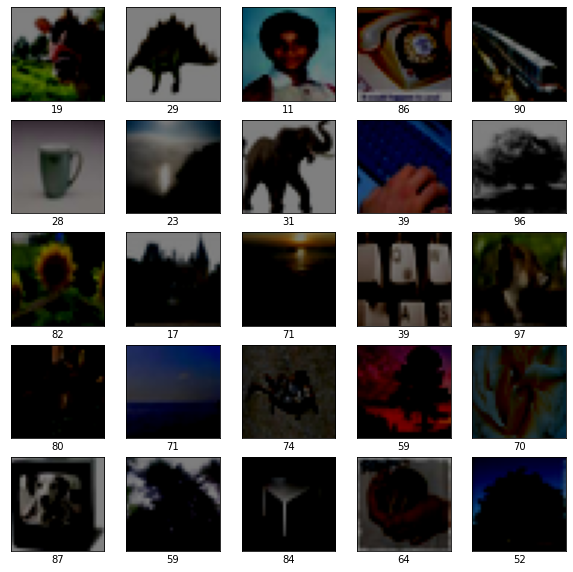

In [4]:
#Quelle
#https://matplotlib.org/stable/tutorials/introductory/pyplot.html#sphx-glr-tutorials-introductory-pyplot-py

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train_new[i])
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(y_train_new[i][0])
plt.show()

In [31]:
#Quelle
#https://github.com/hiaghosh/Defensive-Distillation/blob/master/models/cifar10/cifar10.py
initial_learning_rate = 0.001

def lr_step_decay(epoch, lr):
    drop_rate = 0.5
    epochs_drop = 10.0
    return initial_learning_rate * math.pow(drop_rate, math.floor(epoch/epochs_drop))

In [6]:
#Create and Train the Base Model with CIFAR90 classes
#Quelle
#Architektur CNN: https://arxiv.org/pdf/1608.04644.pdf
#https://www.tensorflow.org/guide/keras/sequential_model
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(32, 32, 3)),  
  tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
  tf.keras.layers.MaxPooling2D(pool_size=(2,2)),   
  tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),  
  tf.keras.layers.Conv2D(128, (3, 3), activation='relu'), 
  tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
  tf.keras.layers.Flatten(),  
  tf.keras.layers.Dense(256,activation='relu'),
  tf.keras.layers.Dropout(rate=0.5),
  tf.keras.layers.Dense(256,activation='relu'),
  tf.keras.layers.Dense(100, activation='softmax')
])
model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, decay=1e-6, momentum=0.9, nesterov=True),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

model.summary()

#Quelle
#https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint

checkpoint_filepath = 'tmp/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

#Quelle
#https://www.tensorflow.org/guide/keras/train_and_evaluate

history = model.fit(
    x_train_new,
    y_train_new,
    epochs=50,
    batch_size=128,
    validation_data=(x_test_new, y_test_new),
    callbacks=[model_checkpoint_callback,LearningRateScheduler(lr_step_decay, verbose=1)]
)
model.load_weights(checkpoint_filepath)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 64)        1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 128)       73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10, 10, 128)       147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 3200)              0

Epoch 31/50

Epoch 00031: LearningRateScheduler reducing learning rate to 0.00125.
352/352 [==============================] - 8s 24ms/step - loss: 1.1328 - accuracy: 0.6628 - val_loss: 2.1579 - val_accuracy: 0.4660
Epoch 32/50

Epoch 00032: LearningRateScheduler reducing learning rate to 0.00125.
352/352 [==============================] - 8s 24ms/step - loss: 1.0844 - accuracy: 0.6734 - val_loss: 2.1738 - val_accuracy: 0.4664
Epoch 33/50

Epoch 00033: LearningRateScheduler reducing learning rate to 0.00125.
352/352 [==============================] - 8s 24ms/step - loss: 1.0536 - accuracy: 0.6800 - val_loss: 2.2098 - val_accuracy: 0.4701
Epoch 34/50

Epoch 00034: LearningRateScheduler reducing learning rate to 0.00125.
352/352 [==============================] - 8s 24ms/step - loss: 1.0458 - accuracy: 0.6813 - val_loss: 2.2200 - val_accuracy: 0.4690
Epoch 35/50

Epoch 00035: LearningRateScheduler reducing learning rate to 0.00125.
352/352 [==============================] - 8s 24ms/step -

In [7]:
# Save the entire model for Transfer Learning
!mkdir -p saved_models_cifar
model.save('saved_models_cifar/base_model_cifar90')

INFO:tensorflow:Assets written to: saved_models_cifar/base_model_cifar90/assets


In [8]:
#Quelle
#https://www.tensorflow.org/tutorials/images/transfer_learning

def display_history(history, title):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()),1])
    plt.title(title)

    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.ylim([0,1.0])
    plt.title(title)
    plt.xlabel('epoch')
    plt.show()

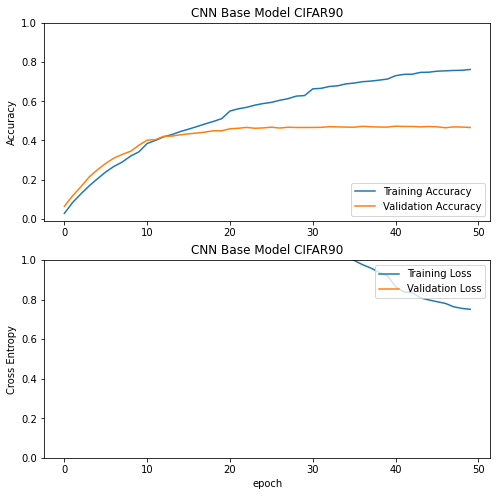

In [9]:
# Display training curve 
display_history(history, "CNN Base Model CIFAR90")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


35


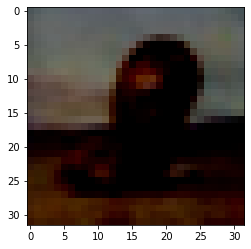

In [10]:
#Predict random image
y=model.predict(x_test_new)
print(np.argmax(y[1500]))
plt.imshow(x_test_new[1500], cmap=plt.cm.binary)

In [12]:
# Evaluate model accuracy
loss, acc = model.evaluate(x_test_new, y_test_new, verbose=2)
print('Accuracy: {:5.2f}%'.format(100 * acc))

print(model.predict(x_test_new).shape)

282/282 - 1s - loss: 2.3545 - accuracy: 0.4727
Accuracy: 47.27%
(9000, 100)


<h2>Transfer Learning

In [13]:
# Load the Model for Transfer Learning
new_model = tf.keras.models.load_model('saved_models_cifar/base_model_cifar90')

#Freeze the layers on the model
new_model.trainable = False

# Check its architecture
new_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 64)        1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 128)       73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10, 10, 128)       147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 3200)              0

In [15]:
# Evaluate the restored model
loss, acc = new_model.evaluate(x_test_new, y_test_new, verbose=2)
print('Restored model, accuracy: {:5.2f}%'.format(100 * acc))

print(new_model.predict(x_test_new).shape)

282/282 - 1s - loss: 2.3545 - accuracy: 0.4727
Restored model, accuracy: 47.27%
(9000, 100)


In [16]:
#Load CIFAR10 Dataset
#Quelle
#https://www.tensorflow.org/api_docs/python/tf/keras/datasets/cifar10/load_data
(x_train_cif10, y_train_cif10), (x_test_cif10, y_test_cif10) = datasets.cifar10.load_data()

# Define per-fold score containers
acc_per_fold = []
loss_per_fold = []

In [17]:
# Normalize pixel values to be between 0 and 1
x_train_cif10 = x_train_cif10 / 255.0 - 0.5
x_test_cif10 = x_test_cif10 / 255.0 - 0.5

#inputs and targets for kFold training set
inputs = x_train_cif10
targets = y_train_cif10

<h2>Add a classifier head</h2>

Create a new model by adding a classifier on top of the base model.

In [18]:
#Quelle
#https://github.com/PacktPublishing/Hands-On-Transfer-Learning-with-TensorFlow-2.0-Video
def build_mnist_model(base_model):
  model = tf.keras.models.Sequential()
  for layer in base_model.layers[:-4]:
        layer.trainable = False
        model.add(layer)
        print('Layer ' + layer.name + ' frozen.')
  model.add(tf.keras.layers.Dense(256,activation='relu')),
  model.add(tf.keras.layers.Dropout(rate=0.5)),
  model.add(tf.keras.layers.Dense(256,activation='relu')),
  model.add(tf.keras.layers.Dense(100, activation='softmax'))
  return model

In [19]:
#Quelle
#https://scikit-learn.org/stable/modules/cross_validation.html#k-fold
num_folds = 10

# Define the K-fold Cross Validator
kfold = KFold(n_splits=num_folds, shuffle=True)


# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in kfold.split(inputs, targets):

    #Create and Train the Model for MNIST 7-9
    #Quelle
    #Architektur CNN: https://arxiv.org/pdf/1608.04644.pdf
    #https://www.tensorflow.org/guide/keras/sequential_model
    transfer_model = build_mnist_model(new_model)
    
    #LearningRate WarmUp -> kein Erfolg-> schriftlich festhalten dass wir neu trainiert haben    
    transfer_model.compile(
        optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, decay=1e-6, momentum=0.9, nesterov=True),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy'],
    )

    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')
    #model.summary()

    #Quelle
    #https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint
    
    checkpoint_filepath = f'tmp/tl_checkpoint{fold_no}'
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True)
    
    #Quelle
    #https://www.tensorflow.org/guide/keras/train_and_evaluate
    #Transfer Learning of the Model with CIFAR10 Dataset
    history = transfer_model.fit(
        inputs[train], targets[train],
        epochs=50,
        batch_size=128,
        validation_data=(inputs[test], targets[test]),
        callbacks=[model_checkpoint_callback, LearningRateScheduler(lr_step_decay, verbose=1)]
    )

    #model.load_weights(checkpoint_filepath)
    # Generate generalization metrics
    scores = transfer_model.evaluate(inputs[test], targets[test], verbose=0)
    print(transfer_model.metrics_names)
    print(f'Score for fold {fold_no}: {transfer_model.metrics_names[0]} of {scores[0]}; {transfer_model.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])
    
    # Save the entire model
    !mkdir -p saved_models_mnist_kfold
    transfer_model.save(f'saved_models_cifar_kfold/tl_model_cifar_{fold_no}')
    
    # Increase fold number
    fold_no = fold_no + 1

# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

Layer conv2d frozen.
Layer conv2d_1 frozen.
Layer max_pooling2d frozen.
Layer conv2d_2 frozen.
Layer conv2d_3 frozen.
Layer max_pooling2d_1 frozen.
Layer flatten frozen.
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/50

Epoch 00001: LearningRateScheduler reducing learning rate to 0.01.
352/352 [==============================] - 7s 19ms/step - loss: 1.7185 - accuracy: 0.4474 - val_loss: 0.9553 - val_accuracy: 0.6630
Epoch 2/50

Epoch 00002: LearningRateScheduler reducing learning rate to 0.01.
352/352 [==============================] - 7s 19ms/step - loss: 0.9904 - accuracy: 0.6502 - val_loss: 0.8675 - val_accuracy: 0.6946
Epoch 3/50

Epoch 00003: LearningRateScheduler reducing learning rate to 0.01.
352/352 [==============================] - 7s 19ms/step - loss: 0.8607 - accuracy: 0.6979 - val_loss: 0.8261 - val_accuracy: 0.7192
Epoch 4/50

Epoch 00004: LearningRateScheduler reducing learning rate to 0.01.
352/352 [============

352/352 [==============================] - 7s 19ms/step - loss: 0.0987 - accuracy: 0.9656 - val_loss: 1.1617 - val_accuracy: 0.7550
Epoch 39/50

Epoch 00039: LearningRateScheduler reducing learning rate to 0.00125.
352/352 [==============================] - 7s 19ms/step - loss: 0.0954 - accuracy: 0.9653 - val_loss: 1.1682 - val_accuracy: 0.7514
Epoch 40/50

Epoch 00040: LearningRateScheduler reducing learning rate to 0.00125.
352/352 [==============================] - 7s 19ms/step - loss: 0.0989 - accuracy: 0.9646 - val_loss: 1.1760 - val_accuracy: 0.7528
Epoch 41/50

Epoch 00041: LearningRateScheduler reducing learning rate to 0.000625.
352/352 [==============================] - 7s 19ms/step - loss: 0.0905 - accuracy: 0.9689 - val_loss: 1.1843 - val_accuracy: 0.7552
Epoch 42/50

Epoch 00042: LearningRateScheduler reducing learning rate to 0.000625.
352/352 [==============================] - 7s 19ms/step - loss: 0.0921 - accuracy: 0.9675 - val_loss: 1.1932 - val_accuracy: 0.7570
Epoch 

352/352 [==============================] - 7s 20ms/step - loss: 0.4814 - accuracy: 0.8251 - val_loss: 0.8308 - val_accuracy: 0.7368
Epoch 11/50

Epoch 00011: LearningRateScheduler reducing learning rate to 0.005.
352/352 [==============================] - 7s 20ms/step - loss: 0.4141 - accuracy: 0.8513 - val_loss: 0.8197 - val_accuracy: 0.7460
Epoch 12/50

Epoch 00012: LearningRateScheduler reducing learning rate to 0.005.
352/352 [==============================] - 7s 20ms/step - loss: 0.3562 - accuracy: 0.8730 - val_loss: 0.8597 - val_accuracy: 0.7494
Epoch 13/50

Epoch 00013: LearningRateScheduler reducing learning rate to 0.005.
352/352 [==============================] - 7s 20ms/step - loss: 0.3251 - accuracy: 0.8829 - val_loss: 0.8712 - val_accuracy: 0.7446
Epoch 14/50

Epoch 00014: LearningRateScheduler reducing learning rate to 0.005.
352/352 [==============================] - 7s 20ms/step - loss: 0.3096 - accuracy: 0.8868 - val_loss: 0.8906 - val_accuracy: 0.7450
Epoch 15/50

Epo

352/352 [==============================] - 7s 20ms/step - loss: 0.1134 - accuracy: 0.9605 - val_loss: 1.1559 - val_accuracy: 0.7524
Epoch 35/50

Epoch 00035: LearningRateScheduler reducing learning rate to 0.00125.
352/352 [==============================] - 7s 20ms/step - loss: 0.1078 - accuracy: 0.9631 - val_loss: 1.1665 - val_accuracy: 0.7506
Epoch 36/50

Epoch 00036: LearningRateScheduler reducing learning rate to 0.00125.
352/352 [==============================] - 7s 20ms/step - loss: 0.1092 - accuracy: 0.9615 - val_loss: 1.1828 - val_accuracy: 0.7532
Epoch 37/50

Epoch 00037: LearningRateScheduler reducing learning rate to 0.00125.
352/352 [==============================] - 7s 20ms/step - loss: 0.1022 - accuracy: 0.9643 - val_loss: 1.1873 - val_accuracy: 0.7530
Epoch 38/50

Epoch 00038: LearningRateScheduler reducing learning rate to 0.00125.
352/352 [==============================] - 7s 20ms/step - loss: 0.0999 - accuracy: 0.9651 - val_loss: 1.1751 - val_accuracy: 0.7534
Epoch 39

352/352 [==============================] - 7s 20ms/step - loss: 0.6565 - accuracy: 0.7650 - val_loss: 0.7676 - val_accuracy: 0.7456
Epoch 7/50

Epoch 00007: LearningRateScheduler reducing learning rate to 0.01.
352/352 [==============================] - 7s 20ms/step - loss: 0.6080 - accuracy: 0.7858 - val_loss: 0.7942 - val_accuracy: 0.7384
Epoch 8/50

Epoch 00008: LearningRateScheduler reducing learning rate to 0.01.
352/352 [==============================] - 7s 20ms/step - loss: 0.5615 - accuracy: 0.7987 - val_loss: 0.7837 - val_accuracy: 0.7460
Epoch 9/50

Epoch 00009: LearningRateScheduler reducing learning rate to 0.01.
352/352 [==============================] - 7s 20ms/step - loss: 0.5243 - accuracy: 0.8116 - val_loss: 0.7922 - val_accuracy: 0.7400
Epoch 10/50

Epoch 00010: LearningRateScheduler reducing learning rate to 0.01.
352/352 [==============================] - 7s 20ms/step - loss: 0.4824 - accuracy: 0.8273 - val_loss: 0.8134 - val_accuracy: 0.7448
Epoch 11/50

Epoch 0001

352/352 [==============================] - 7s 20ms/step - loss: 0.1411 - accuracy: 0.9482 - val_loss: 1.0813 - val_accuracy: 0.7546
Epoch 31/50

Epoch 00031: LearningRateScheduler reducing learning rate to 0.00125.
352/352 [==============================] - 7s 20ms/step - loss: 0.1306 - accuracy: 0.9535 - val_loss: 1.0870 - val_accuracy: 0.7560
Epoch 32/50

Epoch 00032: LearningRateScheduler reducing learning rate to 0.00125.
352/352 [==============================] - 7s 20ms/step - loss: 0.1230 - accuracy: 0.9580 - val_loss: 1.0986 - val_accuracy: 0.7542
Epoch 33/50

Epoch 00033: LearningRateScheduler reducing learning rate to 0.00125.
352/352 [==============================] - 7s 20ms/step - loss: 0.1189 - accuracy: 0.9584 - val_loss: 1.1009 - val_accuracy: 0.7560
Epoch 34/50

Epoch 00034: LearningRateScheduler reducing learning rate to 0.00125.
352/352 [==============================] - 7s 20ms/step - loss: 0.1176 - accuracy: 0.9578 - val_loss: 1.1080 - val_accuracy: 0.7560
Epoch 35

352/352 [==============================] - 7s 20ms/step - loss: 0.9888 - accuracy: 0.6471 - val_loss: 0.8573 - val_accuracy: 0.7050
Epoch 3/50

Epoch 00003: LearningRateScheduler reducing learning rate to 0.01.
352/352 [==============================] - 7s 20ms/step - loss: 0.8632 - accuracy: 0.6957 - val_loss: 0.8334 - val_accuracy: 0.7032
Epoch 4/50

Epoch 00004: LearningRateScheduler reducing learning rate to 0.01.
352/352 [==============================] - 7s 20ms/step - loss: 0.7769 - accuracy: 0.7232 - val_loss: 0.7902 - val_accuracy: 0.7258
Epoch 5/50

Epoch 00005: LearningRateScheduler reducing learning rate to 0.01.
352/352 [==============================] - 7s 20ms/step - loss: 0.7084 - accuracy: 0.7479 - val_loss: 0.7918 - val_accuracy: 0.7248
Epoch 6/50

Epoch 00006: LearningRateScheduler reducing learning rate to 0.01.
352/352 [==============================] - 7s 20ms/step - loss: 0.6562 - accuracy: 0.7673 - val_loss: 0.7842 - val_accuracy: 0.7320
Epoch 7/50

Epoch 00007:

352/352 [==============================] - 7s 20ms/step - loss: 0.1491 - accuracy: 0.9474 - val_loss: 1.1549 - val_accuracy: 0.7362
Epoch 27/50

Epoch 00027: LearningRateScheduler reducing learning rate to 0.0025.
352/352 [==============================] - 7s 20ms/step - loss: 0.1513 - accuracy: 0.9466 - val_loss: 1.1663 - val_accuracy: 0.7374
Epoch 28/50

Epoch 00028: LearningRateScheduler reducing learning rate to 0.0025.
352/352 [==============================] - 7s 20ms/step - loss: 0.1439 - accuracy: 0.9487 - val_loss: 1.1529 - val_accuracy: 0.7364
Epoch 29/50

Epoch 00029: LearningRateScheduler reducing learning rate to 0.0025.
352/352 [==============================] - 7s 20ms/step - loss: 0.1390 - accuracy: 0.9508 - val_loss: 1.1671 - val_accuracy: 0.7354
Epoch 30/50

Epoch 00030: LearningRateScheduler reducing learning rate to 0.0025.
352/352 [==============================] - 7s 20ms/step - loss: 0.1346 - accuracy: 0.9520 - val_loss: 1.2131 - val_accuracy: 0.7334
Epoch 31/50


In [24]:
import pandas as pd
# Evaluate all 10 models
accuracy = list()
for i in range(1,11):
    model = tf.keras.models.load_model(f'saved_models_cifar_kfold/tl_model_cifar_{i}')
    model.load_weights(f'tmp/tl_checkpoint{i}')

    loss, acc = model.evaluate(x_test_cif10, y_test_cif10, verbose=2)
    print('Accuracy: {:5.2f}%'.format(100 * acc))
    accuracy.append(acc)
    print(model.predict(x_test_cif10).shape)
    
    df = pd.DataFrame(accuracy, columns=['Scores'])
    df.to_excel('tl_accuracy.xlsx', sheet_name='kfold', index=False)

313/313 - 2s - loss: 1.1869 - accuracy: 0.7494
Accuracy: 74.94%
(10000, 100)
313/313 - 2s - loss: 1.1536 - accuracy: 0.7424
Accuracy: 74.24%
(10000, 100)
313/313 - 2s - loss: 0.8536 - accuracy: 0.7477
Accuracy: 74.77%
(10000, 100)
313/313 - 2s - loss: 1.0103 - accuracy: 0.7462
Accuracy: 74.62%
(10000, 100)
313/313 - 2s - loss: 1.0550 - accuracy: 0.7470
Accuracy: 74.70%
(10000, 100)
313/313 - 2s - loss: 0.8920 - accuracy: 0.7418
Accuracy: 74.18%
(10000, 100)
313/313 - 2s - loss: 1.2501 - accuracy: 0.7483
Accuracy: 74.83%
(10000, 100)
313/313 - 2s - loss: 1.1747 - accuracy: 0.7484
Accuracy: 74.84%
(10000, 100)
313/313 - 2s - loss: 1.3001 - accuracy: 0.7429
Accuracy: 74.29%
(10000, 100)
313/313 - 2s - loss: 0.8410 - accuracy: 0.7447
Accuracy: 74.47%
(10000, 100)


In [ ]:
# Display training curve 
display_history(history, "CNN Model CIFAR90 - CIFAR10 after Transfer Learning")

<h2> Fine Tuning

In [119]:
#Load Model for fine tuning and attacking
fine_tune_model = tf.keras.models.load_model(f'saved_models_cifar_kfold/tl_model_cifar_10')
fine_tune_model.load_weights(f'tmp/tl_checkpoint10')

In [120]:
#Unfreeze all Layers und base model
fine_tune_model.trainable = True

In [121]:
#Print number of layers of model
print('Number of layers in the base model: ', len(fine_tune_model.layers))

Number of layers in the base model:  11


In [122]:
#Quelle
#https://github.com/PacktPublishing/Hands-On-Transfer-Learning-with-TensorFlow-2.0-Video
#fine tune from this layer onwards
fine_tune_at = 4

# Freeze all the layers before the `fine_tune_at` layer
for layer in fine_tune_model.layers[:fine_tune_at]:
  layer.trainable =  False
  print('Layer ' + layer.name + ' frozen.')  

Layer conv2d frozen.
Layer conv2d_1 frozen.
Layer max_pooling2d frozen.
Layer conv2d_2 frozen.


In [123]:
fine_tune_model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, decay=1e-6, momentum=0.9, nesterov=True),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [124]:
checkpoint_filepath = 'tmp/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

#Transfer Learning of the Model with CIFAR10 Dataset
history = fine_tune_model.fit(
    x_train_cif10,
    y_train_cif10,
    epochs=50,
    batch_size=128,
    validation_data=(x_test_cif10, y_test_cif10),
    callbacks=[model_checkpoint_callback, LearningRateScheduler(lr_step_decay, verbose=1)]
)

fine_tune_model.load_weights(checkpoint_filepath)

Epoch 1/50

Epoch 00001: LearningRateScheduler reducing learning rate to 0.001.
391/391 [==============================] - 10s 24ms/step - loss: 0.3725 - accuracy: 0.8771 - val_loss: 0.8177 - val_accuracy: 0.7510
Epoch 2/50

Epoch 00002: LearningRateScheduler reducing learning rate to 0.001.
391/391 [==============================] - 9s 24ms/step - loss: 0.3518 - accuracy: 0.8827 - val_loss: 0.8166 - val_accuracy: 0.7540
Epoch 3/50

Epoch 00003: LearningRateScheduler reducing learning rate to 0.001.
391/391 [==============================] - 9s 24ms/step - loss: 0.3328 - accuracy: 0.8904 - val_loss: 0.8117 - val_accuracy: 0.7531
Epoch 4/50

Epoch 00004: LearningRateScheduler reducing learning rate to 0.001.
391/391 [==============================] - 9s 24ms/step - loss: 0.3177 - accuracy: 0.8942 - val_loss: 0.8298 - val_accuracy: 0.7495
Epoch 5/50

Epoch 00005: LearningRateScheduler reducing learning rate to 0.001.
391/391 [==============================] - 9s 24ms/step - loss: 0.3030 

391/391 [==============================] - 9s 24ms/step - loss: 0.1803 - accuracy: 0.9376 - val_loss: 0.9209 - val_accuracy: 0.7595
Epoch 40/50

Epoch 00040: LearningRateScheduler reducing learning rate to 0.000125.
391/391 [==============================] - 9s 24ms/step - loss: 0.1779 - accuracy: 0.9385 - val_loss: 0.9219 - val_accuracy: 0.7603
Epoch 41/50

Epoch 00041: LearningRateScheduler reducing learning rate to 6.25e-05.
391/391 [==============================] - 9s 24ms/step - loss: 0.1769 - accuracy: 0.9393 - val_loss: 0.9233 - val_accuracy: 0.7600
Epoch 42/50

Epoch 00042: LearningRateScheduler reducing learning rate to 6.25e-05.
391/391 [==============================] - 9s 24ms/step - loss: 0.1800 - accuracy: 0.9385 - val_loss: 0.9220 - val_accuracy: 0.7600
Epoch 43/50

Epoch 00043: LearningRateScheduler reducing learning rate to 6.25e-05.
391/391 [==============================] - 9s 24ms/step - loss: 0.1705 - accuracy: 0.9413 - val_loss: 0.9235 - val_accuracy: 0.7608
Epoc

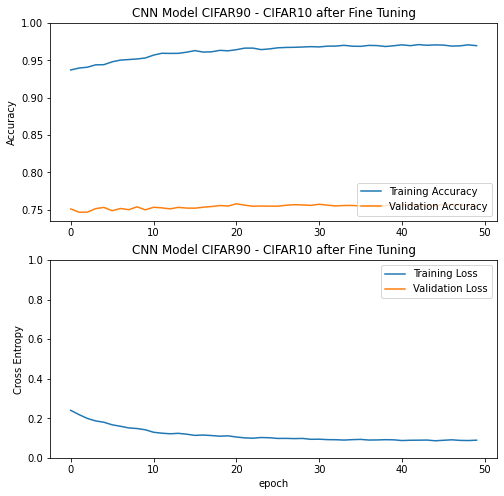

In [96]:
# Display training curve 
display_history(history, "CNN Model CIFAR90 - CIFAR10 after Fine Tuning")

In [4]:
#Import Foolbox Packages
#Quelle
#https://foolbox.readthedocs.io/en/stable/
from foolbox import TensorFlowModel, accuracy, samples, Model, utils, attacks, plot
from foolbox.attacks import LinfPGD, LinfDeepFoolAttack
import pandas as pd

In [125]:
#Run the attack with foolbox
#Quelle
#https://foolbox.readthedocs.io/en/stable/
preprocessing = dict()
bounds = (-0.5, 0.5)
fmodel = TensorFlowModel(fine_tune_model, bounds=bounds, preprocessing=preprocessing)
fmodel = fmodel.transform_bounds((-0.5, 0.5))

attack_labels = tf.convert_to_tensor(y_test_cif10, dtype='int64')
attack_labels = tf.reshape(attack_labels, 10000)
attack_images = tf.convert_to_tensor(x_test_cif10, dtype='float32')

In [126]:
#Quelle
#https://www.kaggle.com/josephvm/generating-adversarial-examples-with-foolbox
predictions = fine_tune_model.predict(attack_images)
orig_predictions = np.argmax(predictions, axis = 1)
print(f"Clean Accuracy:  {np.mean(orig_predictions == attack_labels) * 100:.2f} %") # Accuracy of original images
already_correct = np.sum(orig_predictions != attack_labels) # keep track of how many were already correct


Clean Accuracy:  76.08 %


In [ ]:
#Quelle
#https://foolbox.jonasrauber.de/guide/examples.html
#PGD40 mit 20 Restarts, Table1
import eagerpy as ep
attack_images = ep.astensor(attack_images)
attack_labels = ep.astensor(attack_labels)
attack = attacks.LinfPGD()
epsilons = [
        0.0,
        0.0002,
        0.0005,
        0.0008,
        0.001,
        0.0015,
        0.002,
        0.003,
        0.01,
        0.1,
        0.15,
        0.2,
        0.25,
        0.3,
        0.5,
        1.0,
    ]

success_rate = np.zeros(len(epsilons))

loop_array = np.array_split(np.arange(attack_images.shape[0]), 20)

for i , idx in enumerate(loop_array): 
    restarts = 20

    truth_array = np.zeros(shape=(len(epsilons),len(idx)), dtype=bool)
    print('Batch: ', i)
    for k in range(restarts):
        print('Restart: ', k)
        raw, clipped, is_adv = attack(fmodel, attack_images[idx], attack_labels[idx], epsilons=epsilons)
        arr = is_adv.numpy()
        truth_array = truth_array | arr
    
    success_rate += np.sum(truth_array, axis=1)
#print(attack_images.shape)
#print('Success Rate:', success_rate / attack_images.shape[0])
    
print("Attack finished!")
print('Success Rate:', success_rate / attack_images.shape[0])
df = pd.DataFrame((success_rate / attack_images.shape[0]), columns=['Success_rate'])
df.to_excel('attack_success_rate.xlsx', sheet_name='attack', index=False)

In [ ]:
#print(raw.shape)
acc = np.zeros(shape=(len(epsilons)))
#for loop über alle epsilons
for i in range(len(epsilons)):
    #print("Labels:      ", np.array(labels))
    print("Epsilon:      ", epsilons[i])
    #foolbox.plot.images(images)
    #plt.show()
    predictions = transfer_model.predict(raw[i])
    adv_predictions = np.argmax(predictions, axis = 1)
    #print("Predictions: ", adv_predictions) # adversarial prediction
    #foolbox.plot.images(raw[i])
    #plt.show()
    print("Accuracy: ", np.mean(adv_predictions == attack_labels[:500])) # Accuracy of adversarial images
    print("--------------------------------------------------------------")
    print("")
    print("--------------------------------------------------------------")
    acc[i] = np.mean(adv_predictions == attack_labels[:500])
plt.plot(epsilons, acc)

In [8]:
print('Versionsinformationen der Module:')
print(sys.executable)
print(sys.version)
print(sys.version_info)
!conda --version
!python --version
print('Tensorflow: ' + tf.__version__)
print('Tensorflow Datasets: ' + tfds.__version__)
print('Scikit Learn: ' + sklearn.__version__)
print('Eagerpy: ' + ep.__version__)
print('Numpy: ' + np.__version__)
print('Matplotlib: ' + matplotlib.__version__)
print('Foolbox: ' + foolbox.__version__)
print('Pandas: ' + pd.__version__)

Versionsinformationen der Module:
/home/fabian/anaconda3/envs/tf-gpu2/bin/python
3.8.8 (default, Feb 24 2021, 21:46:12) 
[GCC 7.3.0]
sys.version_info(major=3, minor=8, micro=8, releaselevel='final', serial=0)
conda 4.10.1
Python 3.8.5
Tensorflow: 2.4.1
Tensorflow Datasets: 3.1.0
Scikit Learn: 0.24.2
Eagerpy: 0.29.0
Numpy: 1.20.2
Matplotlib: 3.4.1
Foolbox: 3.3.1
Pandas: 1.2.4
